# YOLOv2 on PYNQ-Z1 and Movidius NCS: Image example
This example tests the YOLO network with an image file.
### Load required packages

In [3]:
import cv2
import numpy as np
import time
import PIL.Image
from matplotlib import pyplot as plt
%matplotlib inline 

import sys
sys.path.insert(0, '../detectionExample')

from ObjectWrapper import *
from Visualize import *

### Open the Movidius NCS

In [4]:
# Open the Movidius NCS device
detector = ObjectWrapper('../graph')

### Load the image

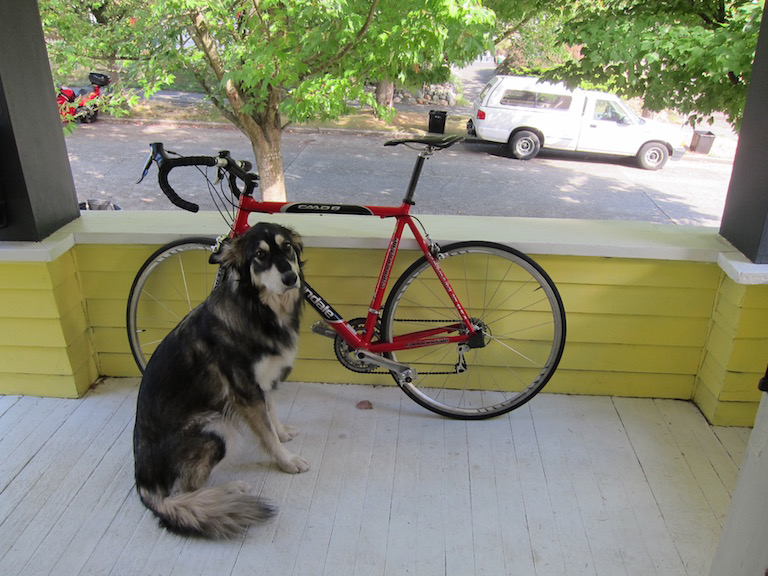

In [5]:
frame = cv2.imread('../data/dog.jpg')
frame = frame[:,:,(2,1,0)]

# Display image in Jupyter notebook
img = PIL.Image.fromarray(frame)
img

###### Resize the image to the size required by the YOLO network (416x416)

Runtime: 0.12380170822143555


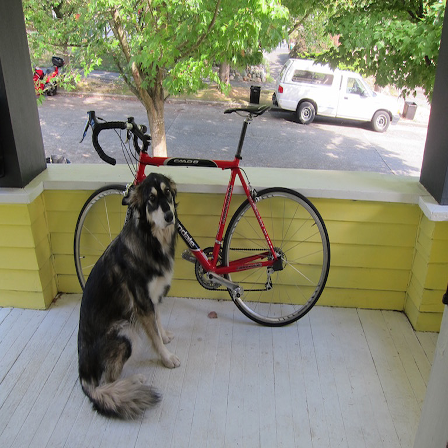

In [4]:
start_time = time.time()

small_frame = cv2.resize(frame, dsize=(416, 416), interpolation=cv2.INTER_CUBIC)
ncs_frame = small_frame.copy()/255.0

end_time = time.time()
print('Runtime:',end_time-start_time)

# Display image in Jupyter notebook
img = PIL.Image.fromarray(small_frame)
img

### Send image to the NCS

/opt/python3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Runtime: 0.9289400577545166


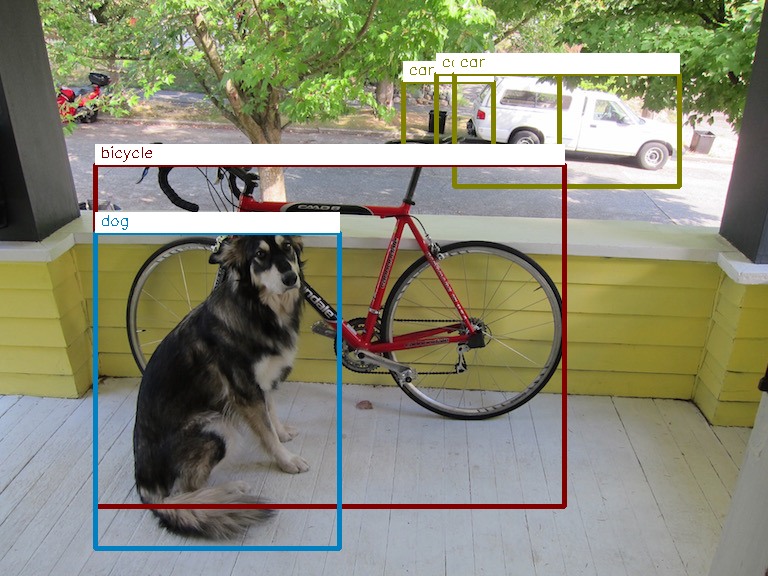

In [6]:
start_time = time.time()

results = detector.Detect(frame)

end_time = time.time()

print ('Runtime:',end_time-start_time)

# Interpret results and draw boxes on the image
img_res = Visualize(frame, results)

# Display image in Jupyter notebook
img = PIL.Image.fromarray(img_res)
img


### Close the NCS device

In [7]:
del detector